In [1]:
!pip install progressbar

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
import warnings

from etl.etl import Data_Correction, AttributeMapping, ratio_missing, impute_na, categorize, etl_transform, etl_save_data

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import progressbar

# magic word for producing visualizations in notebook
%matplotlib inline

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 30000)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [118]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype=str)

mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype=str)

In [119]:
target = mailout_train[['LNR', 'RESPONSE']]
target.set_index('LNR', inplace=True)
target = target.astype(float)

In [120]:
with open('ref_features.pkl', 'rb') as f:
    ref_features = pickle.load(f)
    
with open('attr_mapping.pkl', 'rb') as f:
    attr_mapping = pickle.load(f)

Cleaning the training data

In [121]:
mailout_train_cleaned,_ = etl_transform(mailout_train, attr_mapping, ref_features, scaler=None, apply_scaler=False)

Correcting issues on edge cases...


Checking for irregular values...


[========================================================================] 100%


Decoding missing or unknown values as NaN...


[========================================================================] 100%


getting the subset of the data with the reference features...
Correcting data types...
Assigning float to numeric features...
Assigning string to qualitative features...


Imputing missing values...
Imputing quantitative features...


[========================================================================] 100%
[========================================================================] 100%


Imputing qualitative features...
OneHot Encoding data...


Finishing.


Applying a test-train split on the data

In [122]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train_cleaned, target, stratify=target, test_size=0.2)

In [123]:
y_train_0 = y_train[y_train['RESPONSE']==0].sample(y_train[y_train['RESPONSE']==1].shape[0]*1)
y_train_1 = y_train[y_train['RESPONSE']==1]
y_train_modified = pd.concat([y_train_0, y_train_1])
X_train_modified = X_train.loc[y_train_modified.index]

In [124]:
y_train[y_train['RESPONSE']=='1']

,RESPONSE
LNR,


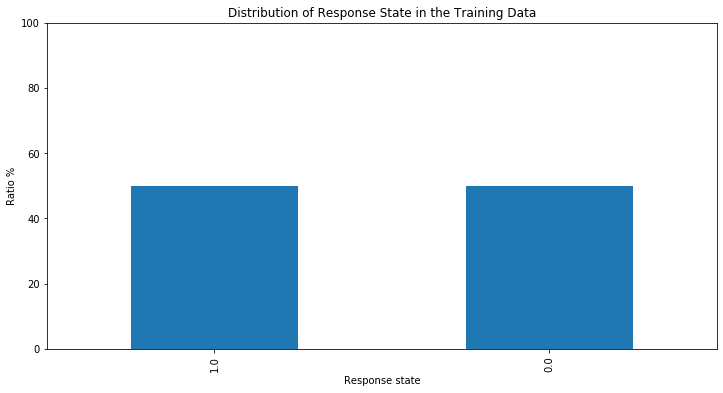

In [125]:
(y_train_modified['RESPONSE'].value_counts()/y_train_modified['RESPONSE'].shape[0]*100).plot(kind='bar', figsize=(12,6))
plt.ylim((0, 100))
plt.xlabel('Response state')
plt.ylabel('Ratio %')
plt.title('Distribution of Response State in the Training Data')
plt.show()

Creating the Supervised Learning pipeline

In [126]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(750)),
    ('clf', GradientBoostingClassifier())
    ])

In [127]:
pipeline.get_params()

{'memory': None,
 'steps': [('scaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('pca',
   PCA(copy=True, iterated_power='auto', n_components=750, random_state=None,
       svd_solver='auto', tol=0.0, whiten=False)),
  ('clf',
   GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                              learning_rate=0.1, loss='deviance', max_depth=3,
                              max_features=None, max_leaf_nodes=None,
                              min_impurity_decrease=0.0, min_impurity_split=None,
                              min_samples_leaf=1, min_samples_split=2,
                              min_weight_fraction_leaf=0.0, n_estimators=100,
                              n_iter_no_change=None, presort='deprecated',
                              random_state=None, subsample=1.0, tol=0.0001,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False))],
 'verbose': False,
 

In [128]:
parameters = {
        'pca__n_components': [100, 150, 200],
        'clf__n_estimators': [500, 750, 1000],
        'clf__max_depth': [3, 4]
        }
    
model = GridSearchCV(pipeline, param_grid=parameters, n_jobs=-1, verbose=10, cv=5)
model.fit(X_train_modified, y_train_modified.values.ravel())

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  85 out of  90 | elapsed:  4.7min remaining:   16.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=750, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('clf',
                                        GradientBoostingClassifier(ccp_alpha=0.0,
                                                                   criterion='friedman_mse',
                                                                   init=None,
                      

In [129]:
print(model.best_params_)

{'clf__max_depth': 4, 'clf__n_estimators': 1000, 'pca__n_components': 200}


### Testing the Model

In [130]:
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

confusion_mat = confusion_matrix(y_val, y_pred)
df_cm = pd.DataFrame(confusion_mat, index=[0, 1], columns=[0, 1])

              precision    recall  f1-score   support

         0.0       0.99      0.56      0.72      8487
         1.0       0.01      0.49      0.03       106

    accuracy                           0.56      8593
   macro avg       0.50      0.53      0.37      8593
weighted avg       0.98      0.56      0.71      8593



In [131]:
df_cm

,0,1
0,4759,3728
1,54,52


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [132]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype=str)

mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype=str)

In [133]:
mailout_test_cleaned,_ = etl_transform(mailout_test, attr_mapping, ref_features, scaler=None, apply_scaler=False)

Correcting issues on edge cases...


Checking for irregular values...


[========================================================================] 100%


Decoding missing or unknown values as NaN...


[========================================================================] 100%


getting the subset of the data with the reference features...
Correcting data types...
Assigning float to numeric features...
Assigning string to qualitative features...


Imputing missing values...
Imputing quantitative features...


[========================================================================] 100%
[========================================================================] 100%


Imputing qualitative features...
OneHot Encoding data...


Finishing.


In [134]:
y_pred = model.predict(mailout_test_cleaned)

In [135]:
mailout_test_predicted = pd.DataFrame({'LNR':mailout_test_cleaned.index, 'RESPONSE':y_pred})

In [136]:
mailout_test_predicted.to_csv('mailout_test_predicted.csv', index=False)

Submission to Kaggle got a score of 0.51736